In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [3]:
data_description = open('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt','r')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [6]:
numeric_cols = train.loc[:,train.dtypes != 'object'].columns

In [7]:
numeric_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [8]:
train_data = train[numeric_cols]
test_data = test[numeric_cols[:-1]]

In [9]:
total_data = pd.concat([train_data,test_data], axis = 0)

In [10]:
total_data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0,0,0,0,0,0,0,6,2006,NaN
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0,24,0,0,0,0,0,4,2006,NaN
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,474,0,0,0,0,0,0,9,2006,NaN
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,80,32,0,0,0,0,700,7,2006,NaN


In [11]:
train.shape[0]

1460

In [12]:
total_data = total_data.drop('Id',axis = 1)
total_data= total_data.loc[:,total_data.isna().sum() ==0].copy()
train_data = total_data.iloc[:train.shape[0],: ]
test_data = total_data.iloc[train.shape[0]:,: ]

In [13]:
len(train_data)

1460

In [14]:
train_data.corr()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.251758,0.307886,0.046474,0.074853,...,-0.045569,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.299475,0.050986,0.004779,0.263116,...,0.271364,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.476224,0.295493,-0.030429,0.593007,...,0.396765,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.144203,0.028942,0.025494,-0.079686,...,-0.023820,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.281986,0.010308,-0.183784,0.199010,...,0.147716,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.240379,0.140024,-0.062419,0.287389,...,0.112581,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
1stFlrSF,-0.251758,0.299475,0.476224,-0.144203,0.281986,0.240379,1.000000,-0.202646,-0.014241,0.566024,...,0.410531,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604
2ndFlrSF,0.307886,0.050986,0.295493,0.028942,0.010308,0.140024,-0.202646,1.000000,0.063353,0.687501,...,0.194561,0.092165,0.208026,0.061989,-0.024358,0.040606,0.081487,0.016197,0.035164,-0.028700
LowQualFinSF,0.046474,0.004779,-0.030429,0.025494,-0.183784,-0.062419,-0.014241,0.063353,1.000000,0.134683,...,-0.021272,-0.025444,0.018251,0.061081,-0.004296,0.026799,0.062157,-0.003793,-0.022174,-0.028921
GrLivArea,0.074853,0.263116,0.593007,-0.079686,0.199010,0.287389,0.566024,0.687501,0.134683,1.000000,...,0.461679,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526


In [15]:
test_data.isna().sum(0)

MSSubClass       0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [16]:
train_x = train_data.copy()
train_y = train['SalePrice'].copy()
test_x = test_data.copy()

In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import ShuffleSplit, cross_validate

lasso = Lasso()

In [18]:
lasso = Lasso(alpha= 1)
cv = ShuffleSplit(n_splits= 50, test_size=0.2)

scores = cross_validate(lasso,
                           X = train_x,
                           y = train_y,
                           cv = cv,
                         return_train_score= True                       
                         
                          )

In [19]:
pd.DataFrame(scores)[['test_score','train_score']].mean(0)

test_score     0.775818
train_score    0.791987
dtype: float64

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate, ShuffleSplit

alphas = [1000,100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

train_scores = []
test_scores = []

for alpha in alphas:
    lasso = Lasso( alpha = alpha)
    cv = ShuffleSplit(n_splits= 50, test_size=0.2, random_state= 10)

    scores = cross_validate(lasso,
                             X = train_x,
                             y = train_y,
                             cv = cv,
                             return_train_score= True   
                              )
    test_mean_score, train_mean_score = pd.DataFrame(scores)[['test_score','train_score']].mean()
    test_scores.append(test_mean_score)
    train_scores.append(train_mean_score)
    

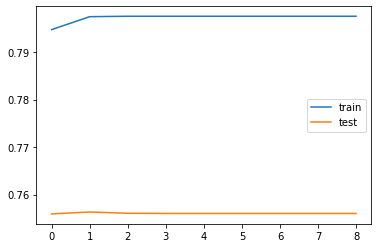

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(len(alphas)), train_scores)
plt.plot(range(len(alphas)), test_scores)


plt.legend(['train','test'])
plt.show()

In [22]:
pd.DataFrame(
    {'train_scores' : train_scores,
     'test_scores' : test_scores,
     'alphas' : alphas
    }
)

,train_scores,test_scores,alphas
0,0.794734,0.755920,1000.00000
1,0.797455,0.756329,100.00000
2,0.797545,0.756054,10.00000
3,0.797546,0.756018,1.00000
4,0.797546,0.756014,0.10000
5,0.797546,0.756013,0.01000
6,0.797546,0.756013,0.00100
7,0.797546,0.756013,0.00010
8,0.797546,0.756013,0.00001


In [23]:
alpha = 100

In [24]:
lasso =Lasso(alpha = 100)
lasso.fit(train_x, train_y)
predicted = lasso.predict(test_x)


<AxesSubplot:>

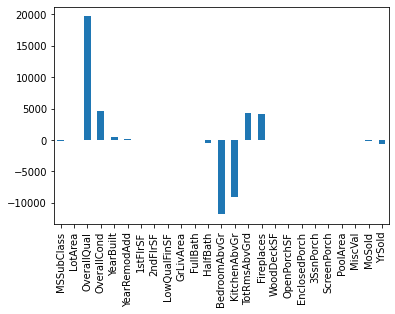

In [25]:
pd.Series(lasso.coef_, index = train_x.columns).plot(kind = 'bar')

<AxesSubplot:>

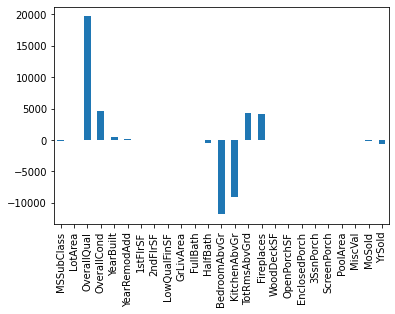

In [26]:
pd.Series(lasso.coef_, index = train_x.columns).plot(kind = 'bar')

In [27]:
sample_submission['SalePrice'] = predicted

In [28]:
sample_submission.to_csv('./lasso_submission.csv', index = False)

In [29]:
sample_submission

,Id,SalePrice
0,1461,129352.743941
1,1462,156066.451365
2,1463,175077.218255
3,1464,205448.159224
4,1465,210031.089885
...,...,...
1454,2915,73431.365380
1455,2916,68795.555788
1456,2917,161638.397803
1457,2918,122942.565005
